In [1]:
push!(LOAD_PATH, "./")
using PyPlot
using BdgSolver

In [2]:
sh = Shape(1000, 1000, 100)
mat = Material("Sn", 0.021931, 0.000618, 0.666666)
pars = Parameters(mat, sh)
sys = System(mat, sh, pars)
H = Hamiltonian(mat, sh, pars);
BdgSolver.print_parameters(sys)

### For comparison with the Python code
EF_3D = 0.5 * (3 * π^2 * mat.ρ)^(2/3)
N0_3D = sqrt(EF_3D*2)/(2.0*π^2) # factor 2
EF_2D = 0.5 * 2 * π*mat.ρ
N0_2D = 1/(0.5 * 4 * π) / sh.Lz
N0 = 1/(0.5 * 4 * π) * pars.ν/sh.Lz
bad_g = 0.18/N0_3D

println("EF_3D = $EF_3D")
println("N0_3D = $N0_3D")
println("EF_2D = $EF_2D")
println("N0_2D = $N0_2D")
println("N0 = $N0")
println("g (crappy) = $bad_g")





--------------------------------------------------------------------------------
--- Shape dimensions -----------------------------------------------------------
--------------------------------------------------------------------------------
--- Lx  =   1000.0 Bohr,   Ly  =   1000.0 Bohr,   Lz = 100.0 Bohr
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--- Material properties --------------------------------------------------------
--------------------------------------------------------------------------------
--- Carrier density:            ρ   = 0.021931         Bohr^{-1},
--- Debye energy:               ħω  = 0.000618        Ha,
--- Electron phonon coupling:   λ   = 0.666666
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--- Derived parameters  ----------

## Integration

Clearly, integrating like this won't be compatible with being able to apply corrections as convolutions to the thermal weight or DOS. I simply can't do "symbolic" integrations for all the corrections and get a function as end result. I'll have to discretize at least part of it, on which I can apply the corrections. I think it's cleanest if I just apply *all* corrections to the DOS:

$$M_{ij} = \Phi_{ij} \int_{DW} d\xi\, N_i(\xi) \int d\Xi\, F(\xi - \Xi, \Gamma_\xi) \frac{ \textrm{tanh} \frac{\beta_c \Xi}{2}}{\Xi}$$

If we put in the Debye-window cutoff manually as a characteristic function, $\chi_{DW}(\xi)$, both integrations become completely equivalent (at least in principle).

$$M_{ij} = \Phi_{ij} \int d\xi\, \chi_{DW}(\xi)N_i(\xi) \int d\Xi\, F(\xi - \Xi, \Gamma_\xi) \frac{ \textrm{tanh} \frac{\beta_c \Xi}{2}}{\Xi}.$$

Reversing the integrations:
$$M_{ij} = \Phi_{ij} \int d\Xi\, \frac{ \textrm{tanh} \frac{\beta_c \Xi}{2}}{\Xi}  \left\{\int d\xi\, F(\xi - \Xi, \Gamma_\xi) \chi_{DW}(\xi)N_i(\xi)\right\}.$$

This way, I can repeatedly keep applying corrections to the DOS. I think. Right?


Note that, if I choose to discretize the DOS, and apply all corrections at the DOS level, I will essentially be multiplying the number of operations (and memory usage) by a factor $\nu$... 

## Thermal determinant

The superconducting and non-superconducting regimes are demarcated by the condition

$$ \det\left(M_{ij} - \delta_{ij}\right) = 0, $$

where $M_{ij}$ is given by

$$M_{ij} = \frac{g}{4} \frac{m}{\pi \hbar^2} \Phi_{ij}
      \int_{DW}d\xi\, \theta(\xi - \epsilon_i) \frac{\tanh\left(\frac{\beta_c \xi}{2}\right)}{\xi}.$$
      
Seeing as how, for a 2D system, the density of states can be written as
$$N_i(\xi) = \frac{m}{\pi \hbar^2} \theta(\xi - \epsilon_i), $$
we can rewrite this as
$$M_{ij} = \frac{g}{4} \Phi_{ij}
      \int_{DW}d\xi\, N_i(\xi) \frac{\tanh\left(\frac{\beta_c \xi}{2}\right)}{\xi}.$$

N(μ) = 8.594366926962346


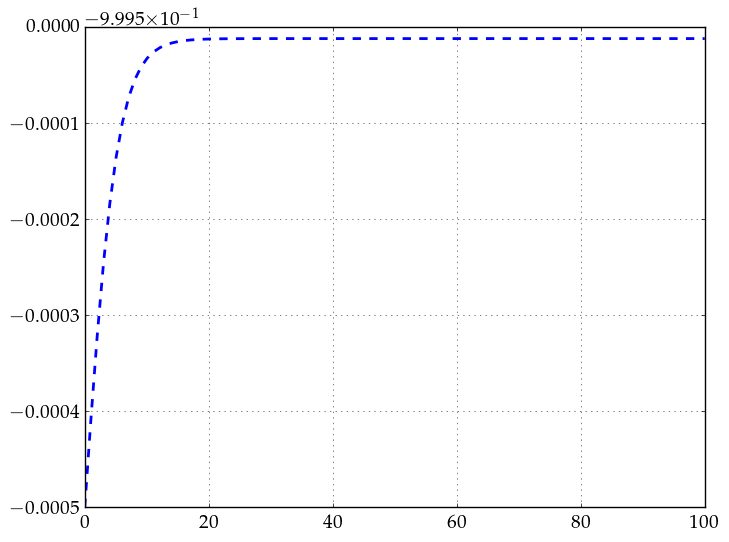

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fcd975c0e10>

g = 0.4873873842708622


In [4]:
βs, Ds = BdgSolver.get_Tc(sys)
plot(βs, Ds, color="blue", linewidth=2.0, linestyle="--")
#fig = figure("Thermal determinant",figsize=(4, 2.5))
#plt[:style][:use]("seaborn-pastel")

The biggest problem I have with this is: my value for $g = \lambda/N(\mu)$ differs immensely from the one I defined in the Python code, $g_\mathrm{Py} = 0.18/N_\mathrm{th}(\mu)$. The Python code defines $g$ through some experimental value for $gN(\mu)$, and divides by the theoretical value $N(0)$.

$g$ differs by a factor of about $2\pi$, while $N$ differs by a factor of 10, precisely. Which is funny...

# TODO:
* Make all the parameters realistic.
* Add missing factors everywhere (I'm thinking, in front of the thermal integral!)
* Add a - \delta_{ij} to the determinant
* Calculate $g$, add it to thermal integral
* Add prefactor to DOS


In [4]:
0.0477*2

0.0954

In [6]:
0.6981 * 2*pi

4.386291662942069

0.5654866776461628